## Mini syrinx model 

For the annealing hypothesis, we would like to test it using a non-random reward contour.
For this, we attempt to generate a reward contour using a syrinx model used by Darshan, Amador, etc.
https://doi.org/10.1038/nature11967

Here, we provide two vectors, pressure and tension, as input.
The model comprises two odes, which produces the labial position x(t) and velocity y(t).

We transform this to generate song, and see the frequency distribution.

From this frequency distribution, we build the reward contour.

In [43]:
import numpy as np
import matplotlib.pyplot as plt         
import queue

In [44]:
from scipy.integrate import solve_ivp

In [45]:
np.random.seed(100)

In [46]:
# Parameters
gamma = 12000 

duration = 0.050 #s
dt = 1/44100 #s  #* 0.1 #1.e-4

Amp = 10

# Trachea parameters
r=-0.9
v=350*100
L=1.9
tau_0=2*L/v # Propagation time along trachea
tau_n=int(tau_0/dt)

In [47]:
# ks = np.linspace(0.16,0.52, 10)
# ps = np.linspace(1852,2084, 10)

# Track position and velocity 
nt = int(duration/dt)
X = np.zeros(nt)          # Labial position
Y = np.zeros(nt)          # Velocity

Building the tension and pressure vectors for input


In [48]:
def sigmoid(x):
      return 1 / (1 + np.exp(-x))

In [121]:
syllable = 4

In [122]:
# RC4
# syllable 1
if syllable == 1:
    def Tension(t):
        """ Generalised exponential waveform """
        return   .3 - .2*np.exp(-200*t) -.00001 * np.exp(200*t) 

        
    def Pressure(t):
        """ Constant """
        return 0.04*np.sin((duration/2 + t)*np.pi*10) + 0.05
# RC5 - test
elif syllable == 2:
    # syllable 2
    def Tension(t):
        """ Generalised exponential waveform """
        Tc = 1#2/3
        return   .3 - .2*np.exp(-Tc*3*100*t) -.00001 * np.exp(Tc*3*100*t) 

    def Pressure(t):
        """ Constant """
        tp = 0.2
        return tp*np.sin((duration/2 + t)*np.pi*10) + 0.05
elif syllable == 3:
    # syllable 3
    def Tension(t):
        """
            Tension1 = 0.1*np.sin(sin_t*np.pi*40) + 0.6
            Tension2 = 0.2*np.sin(sin_t*np.pi*15) + 0.6
            Tension = np.concatenate((Tension1[:int(np.ceil(nt/2))], Tension2[:int(nt-nt/2)]))
        """
        scale = 1
        if isinstance(t, float):
            if t <= duration*scale/2: 
                return 5*np.sin(t*np.pi*40/scale) + 0.6 # old amp 0.1
            elif t <= duration*scale: 
                return 10*np.sin((t-duration*scale/2)*np.pi*15/scale) + 0.6 # old amp 0.2
            else: 
                return 0.0 + 0*t
        elif isinstance(t, np.ndarray):
            Tension1 = 5*np.sin(t*np.pi*40/scale) + 0.6 # old amp 0.1
            Tension2 = 10*np.sin(t*np.pi*15/scale) + 0.6 # old amp 0.2
            Tension3 = 0.0 + 0*t
            return np.concatenate((Tension1[:int(np.ceil(t.size*scale/2))], Tension2[:int(t.size*scale-t.size*scale/2)], Tension3[:int(t.size-t.size*scale)]))        
    
    def Pressure(t):
        """ Pressure = 0.02 * np.ones((nt)) """
        return np.ones((np.asarray(t).shape)) * 2 # old amp 0.16
elif syllable == 4:
    # syllable 4
    def Tension(t):
        """
            Tension1 = 0.1*np.sin(sin_t*np.pi*40) + 0.6
            Tension2 = 0.2*np.sin(sin_t*np.pi*15) + 0.6
            Tension = np.concatenate((Tension1[:int(np.ceil(nt/2))], Tension2[:int(nt-nt/2)]))
        """
        scale = 0.4
        if isinstance(t, float):
            if t <= duration*scale: 
                return 0.8*np.sin(t*np.pi*20/scale) + 0.6 # old amp 0.1
            else: 
                return t*0 + 0.6 # old amp 0.2
        elif isinstance(t, np.ndarray):
            Tension1 = 0.8*np.sin(t*np.pi*20/scale) + 0.6 # old amp 0.1
            Tension2 = t* 0 + 0.6 # old amp 0.2
            return np.concatenate((Tension1[:int(np.ceil(t.size*scale))], Tension2[:int(t.size-t.size*scale)]))
          
    def Pressure(t):
        """ Pressure = 0.02 * np.ones((nt)) """
        return np.ones((np.asarray(t).shape)) * 0.01
        
elif syllable == 5:
    # syllable 5
    def Tension(t):
        """ Tension = 0.2 * np.ones((nt)) """
        return np.ones((np.asarray(t).shape)) * 0.2
        
    def Pressure(t):
        """ Pressure = 0.1 * np.ones((nt)) """
        return np.ones((np.asarray(t).shape)) * 0.1
elif syllable == 6:
    # syllable 6
    def Tension(t):
        """
            Tension1 = 0.1*np.sin(sin_t*np.pi*40) + 0.6
            Tension2 = 0.2*np.sin(sin_t*np.pi*15) + 0.6
            Tension = np.concatenate((Tension1[:int(np.ceil(nt/2))], Tension2[:int(nt-nt/2)]))
        """
        if isinstance(t, float):
            if t <= duration/2: return 0.1*np.sin(t*np.pi*40) + 0.6
            else: return 0.2*np.sin((t-duration/2)*np.pi*15) + 0.6
        elif isinstance(t, np.ndarray):
            Tension1 = 0.1*np.sin(t*np.pi*40) + 0.6
            Tension2 = 0.2*np.sin(t*np.pi*15) + 0.6
            return np.concatenate((Tension1[:int(np.ceil(t.size/2))], Tension2[:int(t.size-t.size/2)]))
        
    def Pressure(t):
        """ Pressure = 0.01*np.sin(sin_t*np.pi*2*100) + 0.02 """
        return 0.01*np.sin(t*np.pi*2*100) + 0.02

In [123]:
%matplotlib inline

[]

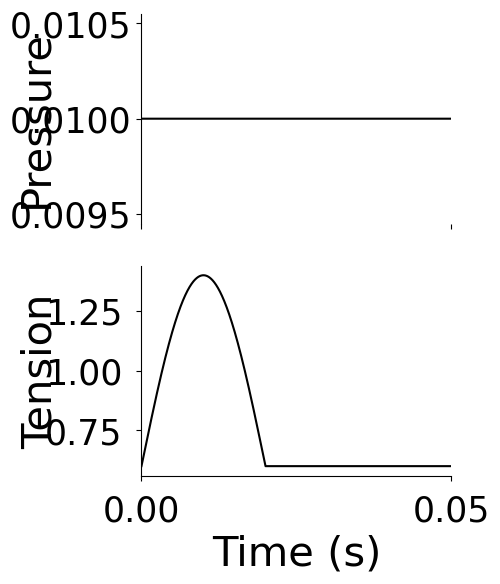

In [124]:
figure, ax = plt.subplots(2, sharex=True)

time_x = np.linspace(0, duration, nt)
ax[0].plot(time_x, Pressure(time_x), color='black')

time_x = np.linspace(0, duration, nt)
ax[1].plot(time_x, Tension(time_x), color='black')

ax[0].set_ylabel('Pressure', fontsize=30)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
# ax[0].set_ylim(0.06,.10)
ax[0].set_xlim(0,.05)
ax[0].set_xticks([])
# ax[0].set_yticks([.06,.10])
ax[0].tick_params(labelsize=25)
ax[0].yaxis.set_label_coords(-0.275,.5)

ax[1].set_ylabel('Tension', fontsize=30)
ax[1].set_xlabel('Time (s)', fontsize=30)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
# ax[1].set_ylim(0,.4)
ax[0].set_xlim(0,.05)
ax[0].set_xticks([0, .05])
# ax[1].set_yticks([0,.4])
ax[1].tick_params(labelsize=25, pad=10)
ax[1].yaxis.set_label_coords(-0.26,.5)

figure.set_size_inches(4, 6, forward=True)

plt.plot()

Propogating these tension and pressure waves through the syrinx using the model (ODE).


In [125]:
def syrinxODE(t, y):
    ''' ODEs used in Amador paper'''
    
    y0, y1 = y
    dydt = [y1,
         -Pressure(t)*(gamma**2) - Tension(t)*(gamma**2)*y0 - (gamma**2)*(y0**3) - gamma*(y0**2)*y1 + (gamma**2)*(y0**2) - gamma*y0*y1
           ]
    return dydt

In [126]:
solution = solve_ivp(syrinxODE, [0, duration], [1, 1], method = "RK45", t_eval = np.linspace(0,duration,nt), rtol = 1e-8, atol = 1e-8)

In [127]:
solution

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  2.269e-05 ...  4.998e-02  5.000e-02]
        y: [[ 1.000e+00  9.811e-01 ...  1.107e-01  1.309e-01]
            [ 1.000e+00 -1.516e+03 ...  1.018e+03  7.575e+02]]
      sol: None
 t_events: None
 y_events: None
     nfev: 35480
     njev: 0
      nlu: 0

In [128]:
# Extract labial position (X) and velocity (Y)
X = solution['y'][0]
Y = solution['y'][1]

In [129]:
# Transform into song
time_x = np.linspace(0, duration, nt)
song = Amp * Pressure(time_x) * Y

In [130]:
## Trachea from Darshan, et. al. https://doi.org/10.1038/ncomms15415

# Input to trachea = output of syrinx
y0 = song.T

# To generate pressure output from trachea
P_i=np.zeros((len(y0)))

# See Fig 1 in Amador paper. Round-about way to implement that.
Buffer = queue.Queue()
for i in np.arange(tau_n):
    Buffer.put(np.random.random())

for i in np.arange(len(y0)):
    P_i[i] = y0[i] - r*Buffer.get();      
    # update_buffer
    Buffer.put(P_i[i])

# P_tr from P_in (ref Amador paper)
BufferB=np.zeros((tau_n))
P_tmp= np.concatenate((BufferB, P_i))
P_t=(1-r)*P_tmp[:-tau_n]


In [131]:
# Plots

In [132]:
time_x = np.linspace(0, duration, nt)

### Plots to quickly visualise each part of the process

Text(0.5, 0, 'Time (s)')

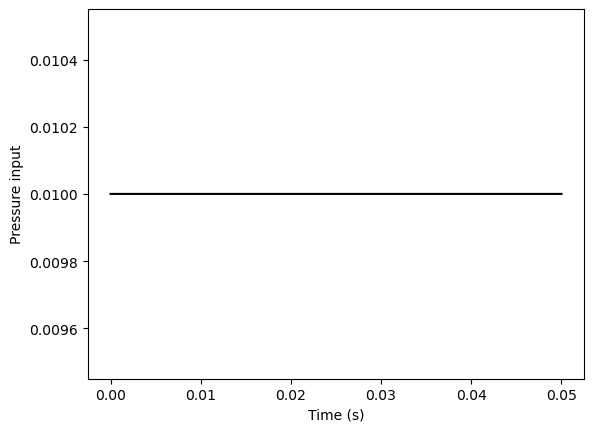

In [133]:
plt.plot(time_x, Pressure(time_x), color='black')
plt.ylabel('Pressure input')
plt.xlabel('Time (s)')

Text(0.5, 0, 'Time (s)')

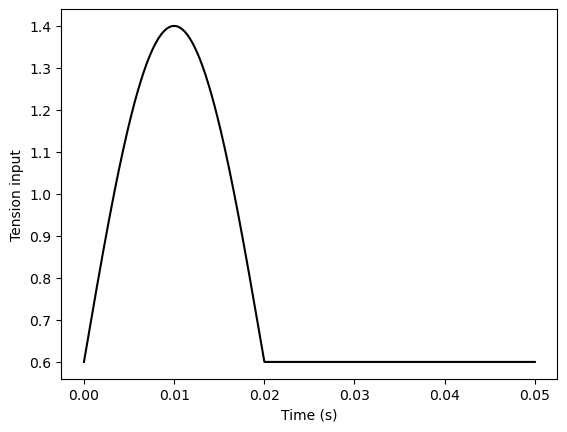

In [134]:
plt.plot(time_x, Tension(time_x), color='black')
plt.ylabel('Tension input')
plt.xlabel('Time (s)')

Text(0.5, 0, 'Time (s)')

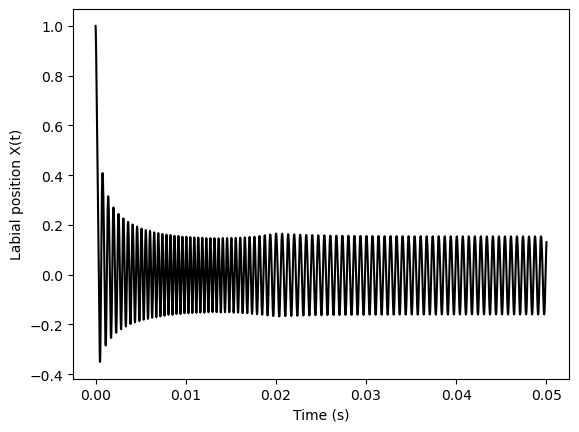

In [135]:
# Labial position (X)

plt.plot(time_x, X, color='black')
plt.ylabel('Labial position X(t)')
plt.xlabel('Time (s)')

Text(0.5, 0, 'Time (s)')

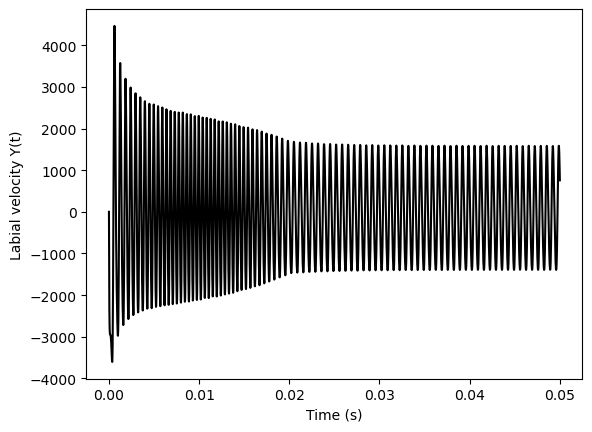

In [136]:
# Labial velocity (Y)

plt.plot(time_x, Y, color='black')
plt.ylabel('Labial velocity Y(t)')
plt.xlabel('Time (s)')

Text(0.5, 0, 'Time (s)')

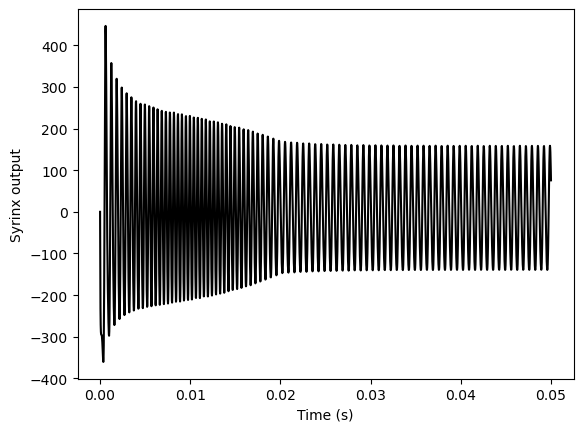

In [137]:
plt.plot(time_x, song, color='black')
plt.ylabel('Syrinx output')
plt.xlabel('Time (s)')

Text(0.5, 0, 'Time (s)')

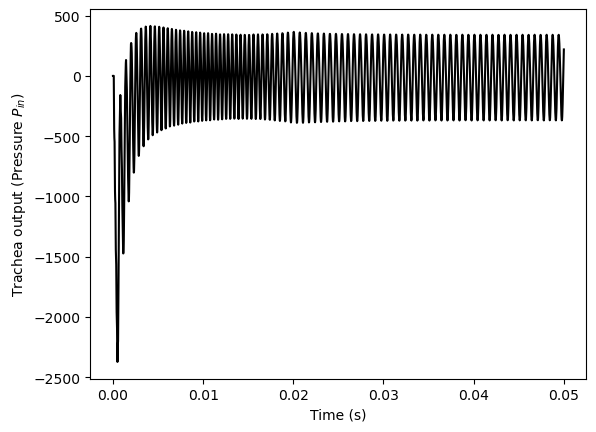

In [138]:
plt.plot(time_x, P_t, color='black')
plt.ylabel('Trachea output (Pressure $P_{in}$)')
plt.xlabel('Time (s)')

[]

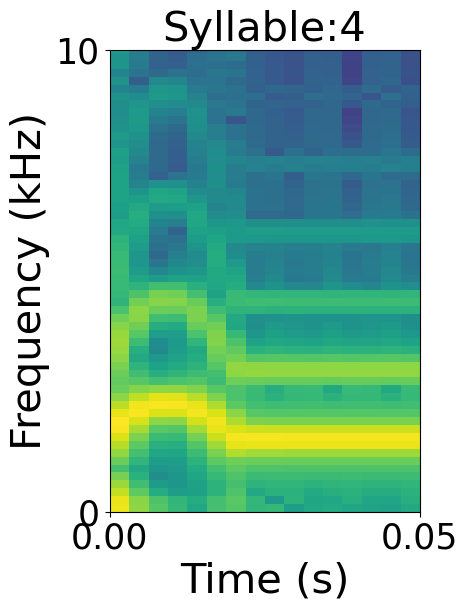

In [139]:
figure, ax = plt.subplots(1)

(spectrumP, freqsP, t, im) = plt.specgram(P_t, Fs=1/dt, NFFT=256, noverlap=128, xextent=[0,.05], cmap='viridis')
im


ax.set_ylabel('Frequency (kHz)', fontsize=30)
ax.set_xlabel('Time (s)', fontsize=30)
ax.set_title(f'Syllable:{syllable}', fontsize=30)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.set_ylim(0,10000)
ax.set_xlim(0,.05)
ax.set_xticks([0,.05])
ax.set_yticks([0, 10000])
ax.set_yticklabels([0, 10])
ax.tick_params(labelsize=25)

figure.set_size_inches(4, 6, forward=True)


plt.plot()

Text(0.5, 0, 'Frequency')

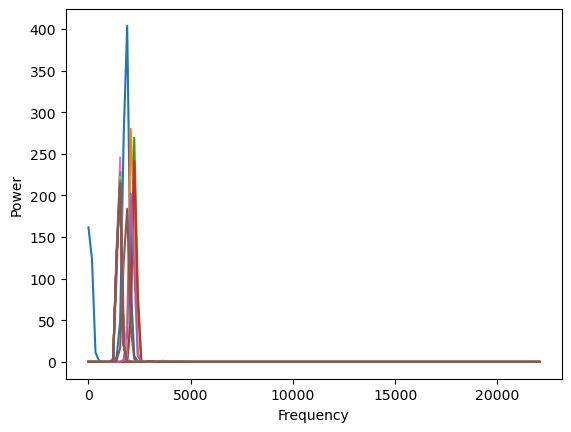

In [140]:
plt.plot(freqsP, spectrumP)
plt.ylabel('Power')
plt.xlabel('Frequency')

Text(0, 0.5, 'Power')

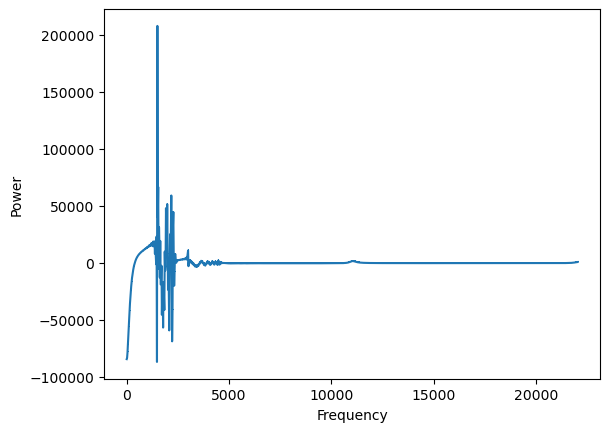

In [141]:
sp = np.fft.rfft(P_t)
freqs_sp = np.arange(sp.size) / (dt * nt)
plt.plot(freqs_sp, sp, marker=',')
plt.xlabel('Frequency')
plt.ylabel('Power')

### Ignore here onwards

In [142]:
# def Tension(t):
#     """
#         Tension1 = 0.1*np.sin(sin_t*np.pi*40) + 0.6
#         Tension2 = 0.2*np.sin(sin_t*np.pi*15) + 0.6
#         Tension = np.concatenate((Tension1[:int(np.ceil(nt/2))], Tension2[:int(nt-nt/2)]))
#     """
#     if isinstance(t, float):
#         if t <= duration/2: return 0.1*np.sin(t*np.pi*40) + 0.6
#         else: return 0.2*np.sin((t-duration/2)*np.pi*15) + 0.6
#     elif isinstance(t, np.ndarray):
#         Tension1 = 0.1*np.sin(t*np.pi*40) + 0.6
#         Tension2 = 0.2*np.sin(t*np.pi*15) + 0.6
#         return np.concatenate((Tension1[:int(np.ceil(t.size/2))], Tension2[:int(t.size-t.size/2)]))
    
# def Pressure(t):
#     """ Pressure = 0.01*np.sin(sin_t*np.pi*2*100) + 0.02 """
#     return 0.01*np.sin(t*np.pi*2*100) + 0.02

In [143]:
# def Tension(t):
#     """ Tension = 0.6 * np.ones((nt)) """
#     return np.ones((np.asarray(t).shape)) * 0.6
    
# def Pressure(t):
#     """ Pressure = 0.02 * np.ones((nt)) """
#     return np.ones((np.asarray(t).shape)) * 0.02

In [144]:
# def Tension(t):
#     """ Tension = 0.2 * np.ones((nt)) """
#     return np.ones((np.asarray(t).shape)) * 0.2
    
# def Pressure(t):
#     """ Pressure = 0.1 * np.ones((nt)) """
#     return np.ones((np.asarray(t).shape)) * 0.1

In [145]:
# def Tension(t):
#     """
#         Tension1 = 0.1*np.sin(sin_t*np.pi*40) + 0.6
#         Tension2 = 0.2*np.sin(sin_t*np.pi*15) + 0.6
#         Tension = np.concatenate((Tension1[:int(np.ceil(nt/2))], Tension2[:int(nt-nt/2)]))
#     """
#     if isinstance(t, float):
#         if t <= duration/2: return 0.1*np.sin(t*np.pi*40) + 0.6
#         else: return 0.2*np.sin((t-duration/2)*np.pi*15) + 0.6
#     elif isinstance(t, np.ndarray):
#         Tension1 = 0.1*np.sin(t*np.pi*40) + 0.6
#         Tension2 = 0.2*np.sin(t*np.pi*15) + 0.6
#         return np.concatenate((Tension1[:int(np.ceil(t.size/2))], Tension2[:int(t.size-t.size/2)]))
    
# def Pressure(t):
#     """ Pressure = 0.02 * np.ones((nt)) """
#     return np.ones((np.asarray(t).shape)) * 0.02

In [146]:
# def Tension(t):
#     """
#         Tension1 = 0.1*np.sin(sin_t*np.pi*40) + 0.2
#         Tension2 = 0.2*np.sin(sin_t*np.pi*15) + 0.2
#         Tension = np.concatenate((Tension1[:int(np.ceil(nt/2))], Tension2[:int(nt-nt/2)]))
#     """
#     if isinstance(t, float):
#         if t <= duration/2: return 0.1*np.sin(t*np.pi*40) + 0.2
#         else: return 0.2*np.sin((t-duration/2)*np.pi*15) + 0.2
#     elif isinstance(t, np.ndarray):
#         Tension1 = 0.1*np.sin(t*np.pi*40) + 0.2
#         Tension2 = 0.2*np.sin(t*np.pi*15) + 0.2
#         return np.concatenate((Tension1[:int(np.ceil(t.size/2))], Tension2[:int(t.size-t.size/2)]))
    
# def Pressure(t):
#     """ Pressure = 0.02 * np.ones((nt)) """
#     return np.ones((np.asarray(t).shape)) * 0.02

In [147]:
# def Tension(t):
#     """ Tension = np.linspace(0.2, 0.1, nt) """
#     return -2 * t + 0.2
    
# def Pressure(t):
#     """ Pressure = 0.1 * np.ones((nt)) """
#     return np.ones((np.asarray(t).shape)) * 0.1

In [148]:
# def Tension(t):
#     """ Tension = np.ones((nt)) * 0.1 """
#     return np.ones((np.asarray(t).shape)) * 0.1
    
# def Pressure(t):
#     """
#         Pressure = 0.02*np.sin(sin_t*np.pi*10) + 0.08
#         where sin_t = np.linspace(duration/2, duration*(3/2), nt)
#     """
#     return 0.02*np.sin((duration/2 + t)*np.pi*10) + 0.08

In [149]:
# def Tension(t):
#     """
#         Tension1 = 0.15*np.sin(sin_t*np.pi*40) + 0.6
#         Tension2 = 0.4*np.sin(sin_t*np.pi*15) + 0.6
#         Tension = np.concatenate((Tension1[:int(np.ceil(nt/2))], Tension2[:int(nt-nt/2)]))
#     """
#     if isinstance(t, float):
#         if t <= duration/2: return 0.15*np.sin(t*np.pi*40) + 0.6
#         else: return 0.2*np.sin((t-duration/2)*np.pi*15) + 0.6
#     elif isinstance(t, np.ndarray):
#         Tension1 = 0.15*np.sin(t*np.pi*40) + 0.6
#         Tension2 = 0.4*np.sin(t*np.pi*15) + 0.6
#         return np.concatenate((Tension1[:int(np.ceil(t.size/2))], Tension2[:int(t.size-t.size/2)]))
    
# def Pressure(t):
#     """ Pressure = 0.16 * np.ones((nt)) """
#     return np.ones((np.asarray(t).shape)) * 0.16

In [150]:
# def Tension(t):
#     """ Tension = np.linspace(0.2, 0, nt) """
#     return -4 * t + 0.2
    
# def Pressure(t):
#     """
#         Pressure = 0.02*np.sin(sin_t*np.pi*10) + 0.14
#         where sin_t = np.linspace(duration/2, duration*(3/2), nt)
#     """
#     return 0.02*np.sin((duration/2 + t)*np.pi*10) + 0.14

In [151]:
# def Tension(t):
#     """ Tension = 0.6 * np.ones((nt)) """
#     return np.ones((np.asarray(t).shape)) * 0.6
    
# def Pressure(t):
#     """ Pressure = 0.1 * np.ones((nt)) """
#     return np.ones((np.asarray(t).shape)) * 0.1

In [152]:
# def Tension(t):
#     """ Tension = 0.6 * np.ones((nt)) """
#     return np.ones((np.asarray(t).shape)) * 0.1
    
# def Pressure(t):
#     """ Pressure = 0.1 * np.ones((nt)) """
#     return 2*np.exp(50**-(t*20))/10 + 0.1

In [153]:
# def Tension(t):
#     """ Tension = 0.6 * np.ones((nt)) """
    
#     return np.ones((np.asarray(t).shape)) * 0.1
    
    
# def Pressure(t):
#     """
#         Pressure1 = 0.05*np.sin(t*np.pi*40) + 0.1
#         Pressure2 = 0.0525*sigmoid(-(t-0.01)*300)+0.1
#         Pressure = np.concatenate((Pressure1[:int(np.ceil(t.size/4))], Pressure2[:int(t.size-t.size/4)]))
#     """
#     if isinstance(t, float):
#         if t <= duration/2: return 0.05*np.sin(t*np.pi*40) + 0.1
#         else: return 0.0525*sigmoid(-((t-duration/4)-0.01)*300)+0.1
#     elif isinstance(t, np.ndarray):
#         Pressure1 = 0.08*np.sin(t*np.pi*40) + 0.04
#         Pressure2 = 0.084*sigmoid(-(t-0.01)*300)+0.04
#         return np.concatenate((Pressure1[:int(np.ceil(t.size/4))], Pressure2[:int(t.size-t.size/4)]))

In [154]:
# def Tension(t):
#     """ Tension = 0.6 * np.ones((nt)) """
    
#     if isinstance(t, float):
#         if t <= duration/3: return 0.2*np.sin(t*np.pi*60) + 0.2
#         else: return -4 * (t-duration/3) + 0.2
#     elif isinstance(t, np.ndarray):
#         Pressure1 = 0.2*np.sin(t*np.pi*60) + 0.2
#         Pressure2 = -4 * t + 0.2
        
#         return np.concatenate((Pressure1[:int(np.ceil(t.size/3))], Pressure2[:int(t.size-t.size/3)]))
    
    
# def Pressure(t):
#     return 0.02*np.sin(t*np.pi*20) + 0.002*np.sin(t*np.pi*200) + 0.06

In [155]:
# def Tension(t):
#     """ Generalised exponential waveform """
#     return   (1.2 * np.exp(-80*t) - np.exp(-300*t)) + 0.3
    
# def Pressure(t):
#     """ Constant """
# #     return np.ones((np.asarray(t).shape)) * 0.02
#     return 0.04*np.sin((duration/2 + t)*np.pi*10) + 0.05

In [156]:
# RC1
# Initial reward contour
# def Tension(t):
#     """ Tension = T_beta * np.ones((nt)) """
    
#     return np.ones((np.asarray(t).shape)) * 0.6
    
# def Pressure(t):
#     """ Pressure = P_alpha * np.ones((nt)) """
    
#     return np.ones((np.asarray(t).shape)) * 0.2